## Analysis of Tuning Properties

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


In [2]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

In [3]:
def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

In [4]:
tc_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'
datadir = data_dir = '/scratches/ramanujan_2/dl543/HDC_PartIII/'

phase='wake'
bin_size=160
single_spikes=False

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))

labels_brain_regions = np.empty(0)

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        dataset = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size, single_spikes, path=data_dir)
        neuron_regions = dataset['metainfo']['neuron_regions']
        labels_brain_regions = np.concatenate((labels_brain_regions, neuron_regions))
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)

print(features_rates.shape)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)
print(filter_hdc.shape)

units:  85  hdc units:  21
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  56  hdc units:  14
(647, 6)
(647,)


In [15]:
# label brain regions
region_names = ['ANT', 'PoS', 'CA1', 'mPFC']

def plot_TI_rate_vs_ff(features_rates, features_FF, labels, label_names, cov='hd', title=None, ax=None, colors=None):
    
    covariates = ['hd', 'omega', 'speed', 'x', 'y', 'time']
    
    sorted_indices = np.argsort(labels)
    sorted_rates = features_rates[sorted_indices]
    sorted_FF = features_FF[sorted_indices]
    
    num_neurons_per_region = []
    for i, name in enumerate(label_names):
        num_neurons_per_region.append(np.where(labels==i)[0].size)
    print(num_neurons_per_region)
    cum_neurons = np.cumsum(np.array(num_neurons_per_region))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    
    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)
    
    if ax is None:
        _, ax = plt.subplots()
    for i, label in enumerate(label_names):
        ax.scatter(sorted_rates[cum_neurons[i]:cum_neurons[i+1], covariates.index(cov)], sorted_FF[cum_neurons[i]:cum_neurons[i+1], covariates.index(cov)], c=colors[i], label=label, alpha=0.4, s=6)
    ax.set_xlabel('TI rates')
    #ax.set_ylabel('TI Fano Factor')
    #ax.legend(prop={'size': 8}, loc='upper right')
    
    if title is not None:
        ax.set_title(title)

[400, 176]
[400, 176]
[400, 176]
[400, 176]
[400, 176]
[400, 176]


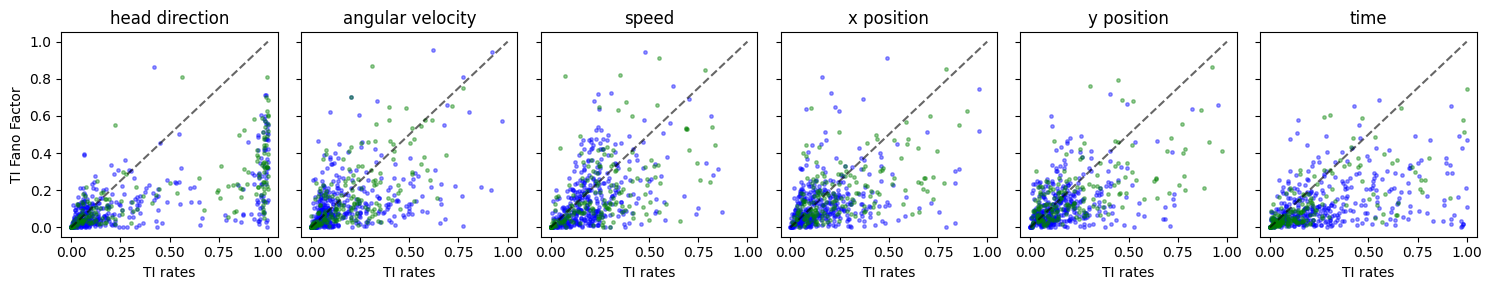

In [10]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 6, sharey=True, sharex=True)
ax = np.array(ax).flatten()

titles = ['head direction', 'angular velocity', 'speed', 'x position', 'y position', 'time']

for i, cov in enumerate(['hd', 'omega', 'speed', 'x', 'y', 'time']):
    ax[i].plot([0,1], [0,1], linestyle='dashed', color='black', alpha=0.6)
    if i==0:
        ax[i].set_ylabel('TI Fano Factor')

    plot_TI_rate_vs_ff(features_rates, features_FF, labels_brain_regions, ['ANT', 'PoS'], cov, f'{titles[i]}', ax[i])
    
plt.tight_layout()

[85, 231, 63, 111, 101, 56]
[85, 231, 63, 111, 101, 56]
[85, 231, 63, 111, 101, 56]
[85, 231, 63, 111, 101, 56]
[85, 231, 63, 111, 101, 56]
[85, 231, 63, 111, 101, 56]


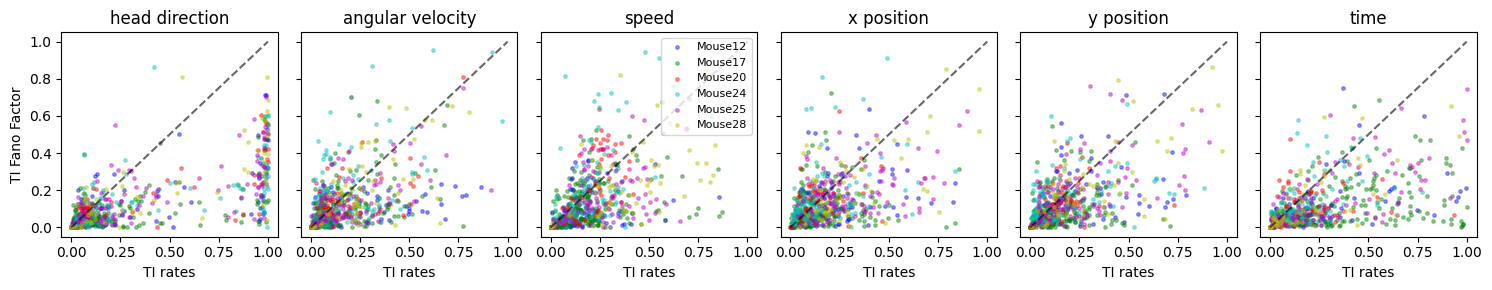

In [11]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 6, sharey=True, sharex=True)
ax = np.array(ax).flatten()

titles = ['head direction', 'angular velocity', 'speed', 'x position', 'y position', 'time']

for i, cov in enumerate(['hd', 'omega', 'speed', 'x', 'y', 'time']):
    ax[i].plot([0,1], [0,1], linestyle='dashed', color='black', alpha=0.6)
    if i==0:
        ax[i].set_ylabel('TI Fano Factor')
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_mice), list(mice_sessions.keys()), cov, f'{titles[i]}', ax[i])
    
    if i==2:
        ax[i].legend(prop={'size': 8}, loc='upper right')
    
plt.tight_layout()

[514, 133]
[514, 133]
[514, 133]
[514, 133]
[514, 133]
[514, 133]


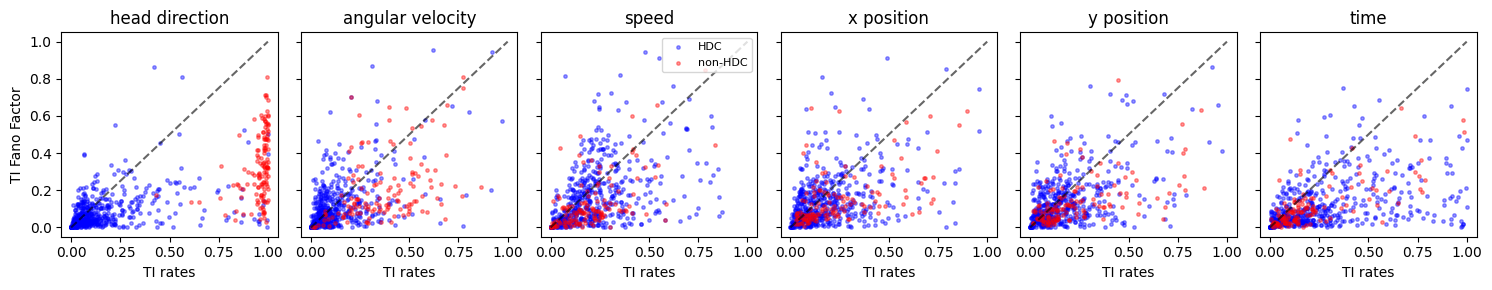

In [17]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 6, sharey=True, sharex=True)
ax = np.array(ax).flatten()

titles = ['head direction', 'angular velocity', 'speed', 'x position', 'y position', 'time']

for i, cov in enumerate(['hd', 'omega', 'speed', 'x', 'y', 'time']):
    ax[i].plot([0,1], [0,1], linestyle='dashed', color='black', alpha=0.6)
    if i==0:
        ax[i].set_ylabel('TI Fano Factor')
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_hdc), ['HDC', 'non-HDC'], cov, f'{titles[i]}', ax[i], colors=['b', 'r'])
    
    if i==2:
        ax[i].legend(prop={'size': 8}, loc='upper right')
    
plt.tight_layout()

# Plots for report

[514, 133]
[514, 133]
[400, 176]
[400, 176]
[85, 231, 63, 111, 101, 56]
[85, 231, 63, 111, 101, 56]


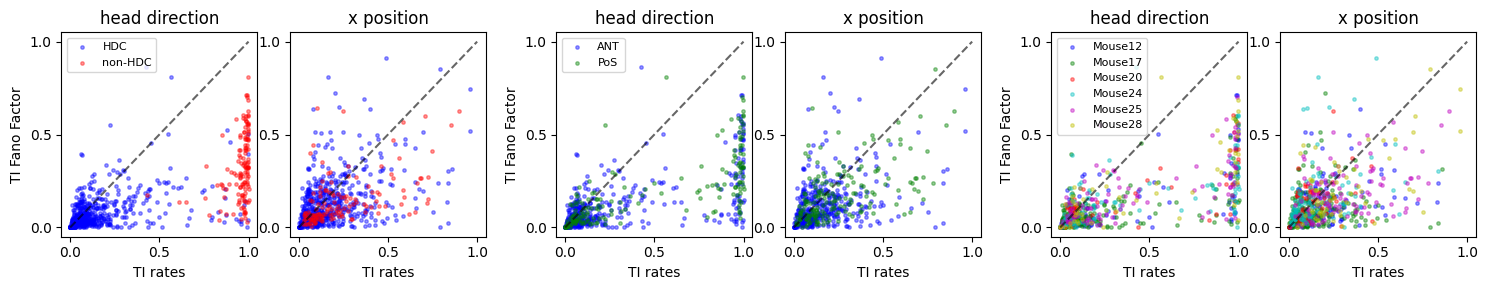

In [36]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import pickle

fig = plt.figure()

gs = gridspec.GridSpec(1,3, figure=fig)


gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
ax = [fig.add_subplot(gs00[0]), fig.add_subplot(gs00[1])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].plot([0,1], [0,1], linestyle='dashed', color='black', alpha=0.6)
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_hdc), ['HDC', 'non-HDC'], cov, f'{titles[i]}', ax[i], colors=['b', 'r'])
    if i==0:
        ax[i].set_ylabel('TI Fano Factor')
        ax[i].legend(prop={'size': 8}, loc='upper left')
    ax[i].set_yticks(ticks=[0, 0.5, 1])
    
file = open('plots/TI_hd_nonhd.pickle', 'wb')
pickle.dump(ax, file)


        
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])
ax = [fig.add_subplot(gs01[0]), fig.add_subplot(gs01[1])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].plot([0,1], [0,1], linestyle='dashed', color='black', alpha=0.6)
    plot_TI_rate_vs_ff(features_rates, features_FF, labels_brain_regions, ['ANT', 'PoS'], cov, f'{titles[i]}', ax[i])
    if i==0:
        ax[i].set_ylabel('TI Fano Factor')
        ax[i].legend(prop={'size': 8}, loc='upper left')
    ax[i].set_yticks(ticks=[0, 0.5, 1])

file = open('plots/TI_regions.pickle', 'wb')
pickle.dump(ax, file)

        
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2])
ax = [fig.add_subplot(gs02[0]), fig.add_subplot(gs02[1])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].plot([0,1], [0,1], linestyle='dashed', color='black', alpha=0.6)
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_mice), list(mice_sessions.keys()), cov, f'{titles[i]}', ax[i])
    if i==0:
        ax[i].set_ylabel('TI Fano Factor')
        ax[i].legend(prop={'size': 8}, loc='upper left')
    ax[i].set_yticks(ticks=[0, 0.5, 1])

file = open('plots/TI_mice.pickle', 'wb')
pickle.dump(ax, file)

        
plt.tight_layout()

## Processing neural datasets
Process neural datasets into python structures for smaller storage size and faster access

## Plot 2D tuning curve

In [8]:
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase='wake'
bin_size = 160  # ms

# data
single_spikes = False
dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                               single_spikes, path='/scratches/ramanujan_2/dl543/HDC_PartIII/')

model_dict = {
    'seed': 123, 
    'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
    'filt_mode': '',  # GLM couplings
    'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
    'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
    'z_mode': '',  # latent covariates
    'hist_len': 0, 
    'folds': 5, 
    'delays': [0], 
    'neurons': dataset_dict['neurons'], 
    'max_count': dataset_dict['max_count'], 
    'bin_size': dataset_dict['bin_size'], 
    'tbin': dataset_dict['tbin'], 
    'model_name': dataset_dict['name'], 
    'tensor_type': torch.float, 
    'jitter': 1e-5, 
}

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below

# model and train/test split based on which validation fold is given by cv_run
modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)

units:  85  hdc units:  21


RuntimeError: Error(s) in loading state_dict for VI_optimized:
	size mismatch for mapping.kernel.kern0.kern0._variance: copying a param with shape torch.Size([66]) from checkpoint, the shape in current model is torch.Size([63]).
	size mismatch for mapping.kernel.kern0.kern1._lengthscale: copying a param with shape torch.Size([66, 1]) from checkpoint, the shape in current model is torch.Size([63, 1]).
	size mismatch for mapping.kernel.kern1._lengthscale: copying a param with shape torch.Size([66, 5]) from checkpoint, the shape in current model is torch.Size([63, 5]).
	size mismatch for mapping.induc_pts.Xu: copying a param with shape torch.Size([66, 64, 6]) from checkpoint, the shape in current model is torch.Size([63, 64, 6]).
	size mismatch for mapping.induc_pts.u_loc: copying a param with shape torch.Size([66, 64]) from checkpoint, the shape in current model is torch.Size([63, 64]).
	size mismatch for mapping.induc_pts.u_scale_tril: copying a param with shape torch.Size([66, 64, 64]) from checkpoint, the shape in current model is torch.Size([63, 64, 64]).
	size mismatch for likelihood.mapping_net.mnet.net.0.weight: copying a param with shape torch.Size([22, 29, 12]) from checkpoint, the shape in current model is torch.Size([21, 29, 12]).
	size mismatch for likelihood.mapping_net.mnet.net.0.bias: copying a param with shape torch.Size([22, 29]) from checkpoint, the shape in current model is torch.Size([21, 29]).

In [ ]:
# 2D search, so there will be steps**2 = 10000 covariate vector inputs
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)


steps = 100
hd_sweep = torch.linspace(0, 2*np.pi, steps)
v_sweep = torch.linspace(np.min(rcov[2]), np.max(rcov[2]), steps)

covariates = torch.cat([
    hd_sweep[:, None].expand(-1, steps).reshape(steps**2, 1),
    rcov[1].mean()*torch.ones((steps**2, 1)),
    v_sweep[None, :].expand(steps, -1).flatten().reshape(steps**2, 1),
    *[rcov[k].mean()*torch.ones((steps**2, 1)) for k in range(3, len(rcov))],
], dim=-1)[None, None, ...] # (tr, neurons, steps, covariate dims)

ne=21
# 7
with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, [ne], MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

In [ ]:
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

In [ ]:
%matplotlib widget

ne=0

lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])

# mean has shape (neurons, steps**2), need to unpack it again
mean = mean.reshape((-1, steps, steps))

plt.figsize=(5, 5)
ax = plt.axes(projection='3d')
ax.plot_surface(covariates[0, 0, :, 0].reshape(100, 100), covariates[0,0,:,2].reshape(100, 100), mean[0, :].numpy(), 
                cmap='viridis', edgecolor='none')
ax.set_xlabel('head direction')
ax.set_xticks([0, np.pi, np.pi*2], labels=['0', '$\pi$', '$2\pi$'])
ax.set_ylabel('speed')
ax.set_zlabel('spike count distributions')


In [ ]:
neuron=12

steps = 100
hd_sweep = torch.linspace(0, 2*np.pi, steps)
v_sweep = torch.linspace(np.min(rcov[2]), np.max(rcov[2]), steps)

covariates = torch.cat([
    hd_sweep[:, None],
    *[rcov[k].mean()*torch.ones((steps, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

ne=neuron
# 7
with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, [ne], MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

fig, ax = plt.subplots(figsize=(10,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 0  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate [Hz]', fontsize=18)
ax.set_xlabel('head direction', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

In [ ]:
neuron=23

steps = 100
hd_sweep = torch.linspace(0, 2*np.pi, steps)
v_sweep = torch.linspace(np.min(rcov[2]), np.max(rcov[2]), steps)

covariates = torch.cat([
    hd_sweep[:, None],
    *[rcov[k].mean()*torch.ones((steps, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

ne=neuron
# 7
with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, [ne], MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 0  # select neuron to plot

ax=axes[0,0]
line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate [Hz]', fontsize=18)
#ax.set_xlabel('head direction', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])


lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
ne = 0  # select neuron to plot

ax=axes[1,0]
line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('Fano Factor', fontsize=18)
ax.set_xlabel('head direction', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])


covariates = torch.cat([
    *[rcov[k].mean()*torch.ones((steps, 1)) for k in range(2)],
    v_sweep[:, None],
    *[rcov[k].mean()*torch.ones((steps, 1)) for k in range(3, len(rcov))],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

# 7
ne=neuron
with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, [ne], MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 0  # select neuron to plot

ax=axes[0,1]
line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
#ax.set_ylabel('firing rate [Hz]', fontsize=18)
#ax.set_xlabel('speed', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])


lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
ne = 0  # select neuron to plot

ax=axes[1,1]
line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
#ax.set_ylabel('Fano Factor', fontsize=18)
ax.set_xlabel('speed', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

plt.tight_layout()